# XMLAD methodology python implementation

## Import libraries

In [1]:
import sys
sys.path.append('attribute_name_files')
sys.path.append('src')

# General libraries
import pandas as pd
import numpy as np

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import seaborn as sn
import graphviz
plt.rc('font', family='sans-serif')

# Scikit learn support functions
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Scikit learn models
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Miscoding libraries
from nescience.miscoding import Miscoding
from nescience.classifier import Classifier

# File with the selected attributes
from nokia_data_attributes import attributes
import preprocessing as xmlad_pre
import models as xmlad_mod
from models import GMMclustering
import ploting as xmlad_plt

visualization = True
save_figures  = True

## Load dataset

In [2]:
data = pd.read_csv("../../../data/mvfst_KPI_new_excel_zeros.csv", encoding = "ISO-8859-1", sep=";", decimal=',')
data = data.select_dtypes(['number'])
data = data.loc[~data['Abs_IdleTime_avg'].isna()]

data.columns= data.columns.str.lower()
original_feat = list(data.columns)
for i in range(len(original_feat)):
    #print(original_feat[i])
    data.rename(columns={original_feat[i]: original_feat[i].replace('_','.')}, inplace=True)

kpi_aux = data['abs.idletime.avg']

data = data.loc[:, data.columns != 'abs.idletime.avg']
data.info()
    
target_kpi = 'abs.idletime.avg'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3951 entries, 0 to 3950
Columns: 188 entries, experiment id to abs.instanttp.timestep.20480ms
dtypes: float64(125), int64(63)
memory usage: 5.7 MB


## Data Preprocessing stage

In [3]:
# Remove features with a large number of null cell (Nans)
data = xmlad_pre.null_cell_cleaning(data)
print('Preprocessing stage 1. Data size: (%d, %d)'%(data.shape[0], data.shape[1]))

# Remove features with low variability
data = xmlad_pre.low_variability_cleaning(data)
print('Preprocessing stage 2. Data size: (%d, %d)'%(data.shape[0], data.shape[1]))

# Remove features with a large number of outliers
data = xmlad_pre.outlier_cleaning(data, 'cols')
print('Preprocessing stage 3. Data size: (%d, %d)'%(data.shape[0], data.shape[1]))

data[target_kpi] = kpi_aux

Preprocessing stage 1. Data size: (3951, 181)
Preprocessing stage 2. Data size: (3951, 120)
Preprocessing stage 3. Data size: (3951, 111)


In [4]:
if (visualization == True):
    print(np.unique(np.array(data.columns)))

['abs.cwin.25,' 'abs.cwin.50,' 'abs.cwin.75,' 'abs.cwin.avg'
 'abs.cwin.max' 'abs.cwin.timestep.10240ms' 'abs.cwin.timestep.1280ms'
 'abs.cwin.timestep.160ms' 'abs.cwin.timestep.20480ms'
 'abs.cwin.timestep.2560ms' 'abs.cwin.timestep.320ms'
 'abs.cwin.timestep.40ms' 'abs.cwin.timestep.5120ms'
 'abs.cwin.volstep.11310kb' 'abs.cwin.volstep.240kb'
 'abs.cwin.volstep.30kb' 'abs.cwin.volstep.4320kb' 'abs.cwin.volstep.90kb'
 'abs.idletime.25,' 'abs.idletime.50,' 'abs.idletime.75,'
 'abs.idletime.avg' 'abs.idletime.firstmb' 'abs.idletime.firstsec'
 'abs.idletime.max' 'abs.idletime.min' 'abs.idletime.timestep.10240ms'
 'abs.idletime.timestep.1280ms' 'abs.idletime.timestep.20480ms'
 'abs.idletime.timestep.2560ms' 'abs.idletime.timestep.320ms'
 'abs.idletime.timestep.40ms' 'abs.idletime.timestep.5120ms'
 'abs.idletime.timestep.640ms' 'abs.idletime.volstep.1000kb'
 'abs.idletime.volstep.11310kb' 'abs.idletime.volstep.1650kb'
 'abs.idletime.volstep.240kb' 'abs.idletime.volstep.30kb'
 'abs.idletime

## Training set preparation

### Discards experiments with a large number of outliers

In [5]:
# Discard rows with high number of outliers (This dataset shall be used to TRAIN the decision tree)
data_non_outliers = xmlad_pre.outlier_cleaning(data, 'rows')
print('Training set preparation stage 1. Data size: (%d, %d)'%(data_non_outliers.shape[0], data_non_outliers.shape[1]))

Training set preparation stage 1. Data size: (255, 112)


### Feature selection based on model-based clustering

In [6]:
data_non_outliers  = data_non_outliers.loc[:, (data_non_outliers.std(axis=0) != 0).values]
correlation_matrix = 1 - data_non_outliers.corr(method="pearson").abs()
projected_samples  = MDS(n_components=2, 
                         dissimilarity='precomputed', 
                         random_state=42).fit_transform(correlation_matrix)

# 2D Clustering
cov_type       = 'full'
cluster2dmodel = GMMclustering(projected_samples)
cluster2d      = cluster2dmodel.predict(int(correlation_matrix.shape[0]/2), 1234, cov_type)

# Feature selection
clusters     = cluster2d.clusters_
centroids    = cluster2d.centroids_
classes      = np.unique(clusters)
closest      = [pairwise_distances_argmin_min(centroids[:][int(n_class)].reshape(1, -1), projected_samples[np.where(clusters == n_class)])[0] for n_class in classes] 
corr_columns = np.array(correlation_matrix.columns.values)
train_cols   = [corr_columns[np.where(clusters == n_class)][int(closest[index])] for index, n_class in enumerate(classes)]
train_cols   = np.delete(train_cols, clusters[corr_columns==target_kpi])

#### Visualization of the 2D clustering (optional)

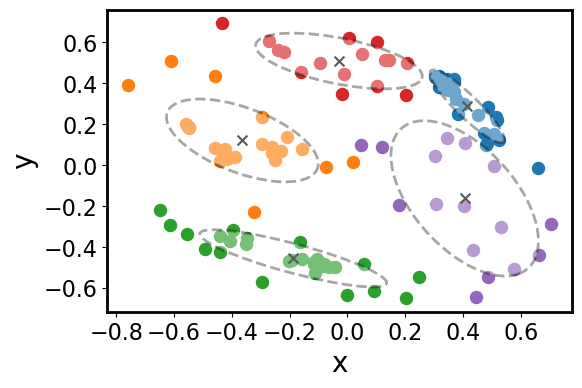

In [7]:
if (visualization == True):
    covariances = cluster2d.covariances_
    xmlad_plt.plot_cluster2d(projected_samples, clusters, centroids, covariances, cov_type)
    if (save_figures == True):
        plt.savefig('images/monroe_dataset/FL_clustering2D.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

### KPI discretization

In [8]:
y_train = data_non_outliers[target_kpi].values.reshape(-1, 1)
n_bins  = int(np.log2(len(y_train))/2)

discretization_model = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans').fit(y_train)
yd = discretization_model.transform(y_train)[:,0]
val, count = np.unique(yd, return_counts=True)
labels = ['Very good', 'Good', 'Fair', 'Bad', 'Very bad']

#### Visualization discretization (optional)

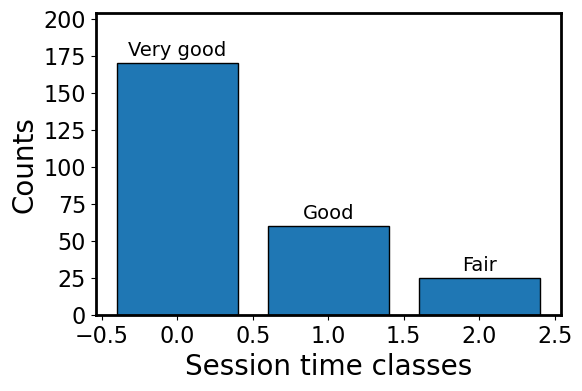

In [9]:
if (visualization == True):
    xmlad_plt.hist_discretization(val, count, labels)
    if (save_figures == True):
        plt.savefig('images/monroe_dataset/FL_discretization.png', 
                    format='png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

## Training of the anomaly detection engine

In [10]:
X_train  = data_non_outliers[train_cols].copy()
vl, cnts = np.unique(yd, return_counts=True)
knowledge, scores, ccp_alphas, best_alpha = xmlad_mod.build_decision_tree(n_bins, 5, X_train, yd, np.min(cnts))

#### Decision tree optimization (optional)

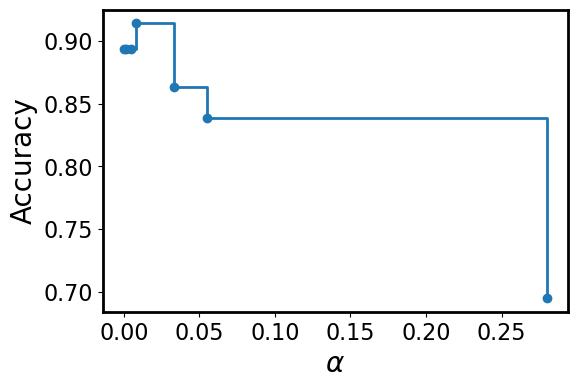

In [11]:
if (visualization == True):
    xmlad_plt.plot_pruning(ccp_alphas, scores)
    if (save_figures == True):
        plt.savefig('images/monroe_dataset/FL_model1_optimization.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

### Display decision tree structure

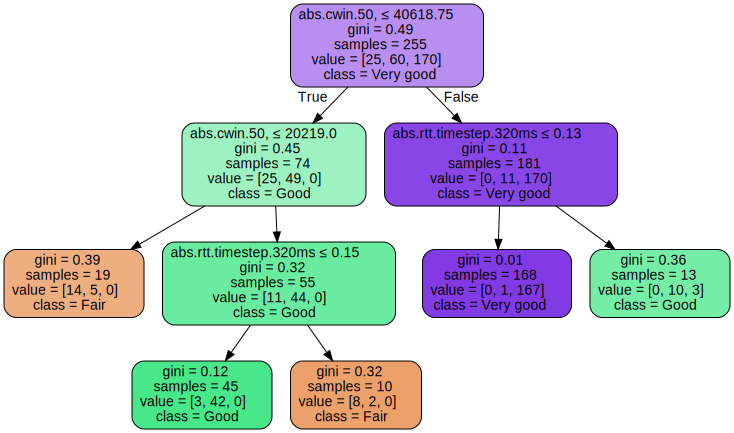

In [12]:
bins = discretization_model.bin_edges_[0].tolist()
data1= pd.cut(x=y_train.reshape(-1), bins = bins, labels=labels[0:val.shape[0]], include_lowest=True)
knowledge_label = DecisionTreeClassifier(max_depth=n_bins, min_samples_leaf=5, ccp_alpha=best_alpha)
knowledge_label.fit(X_train, data1)

dot_data = tree.export_graphviz(knowledge_label, 
                                feature_names = np.array(X_train.columns), 
                                class_names=knowledge_label.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=2,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.format='png'
#graph.format='svg'
filename = graph.render(filename='models/monroe_dataset/model1_file_dl')
graph

## Feature Selection based on the miscoding metric

### Vector of anomalous scenarios

In [13]:
y      = data[target_kpi].values.reshape(-1, 1)
ydt    = discretization_model.transform(y)[:,0]
y_pred = knowledge.predict(data[train_cols])
y_diff = y_pred - ydt
y_diff[y_diff > 0] = 0
data["Diff_Pred"] = y_diff
val, count = np.unique(y_diff, return_counts=True)

#### Ploting the histogram of the differences (optional)

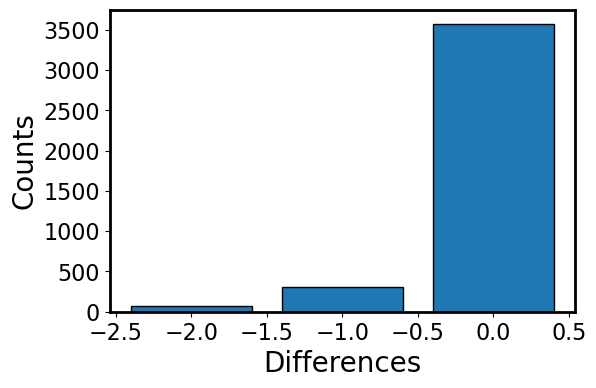

In [14]:
if (visualization == True):
    xmlad_plt.hist_differences(val, count)
    if (save_figures == True):
        plt.savefig('images/monroe_dataset/FL_differences.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

### Miscoding

In [15]:
data_misc    = data.drop(columns =[target_kpi, "Diff_Pred"])
column_names = np.array(data_misc.columns)
n_clusters   = int(np.log2(len(data.index))/2)
n_features   = min(n_clusters * n_clusters, len(data_misc.columns))
miscoding    = Miscoding(redundancy=True).fit(data_misc, data["Diff_Pred"])
mscd         = miscoding.miscoding_features()
best_mscd    = np.argsort(-mscd)[0:n_features]
attributes   = column_names[best_mscd]
print(attributes)

['abs.idletime.max' 'abs.idletime.timestep.10240ms'
 'abs.segmentsizes.timestep.640ms' 'abs.idletime.timestep.320ms'
 'abs.idletime.timestep.1280ms' 'abs.segmentsizes.timestep.320ms'
 'abs.rtt.volstep.1000kb' 'abs.idletime.timestep.2560ms' 'abs.rtt.75,'
 'abs.segmentsizes.firstsec' 'delay' 'abs.idletime.timestep.20480ms'
 'abs.rtt.timestep.5120ms' 'abs.rtt.timestep.10240ms' 'abs.rtt.50,'
 'abs.rtt.volstep.1650kb' 'abs.idletime.timestep.5120ms' 'abs.rtt.avg'
 'abs.rtt.25,' 'abs.idletime.volstep.1650kb' 'abs.rtt.timestep.1280ms'
 'abs.rtt.timestep.2560ms' 'abs.segmentsizes.volstep.240kb'
 'abs.rtt.volstep.240kb' 'abs.idletime.volstep.1000kb']


#### Barplot of miscoding values

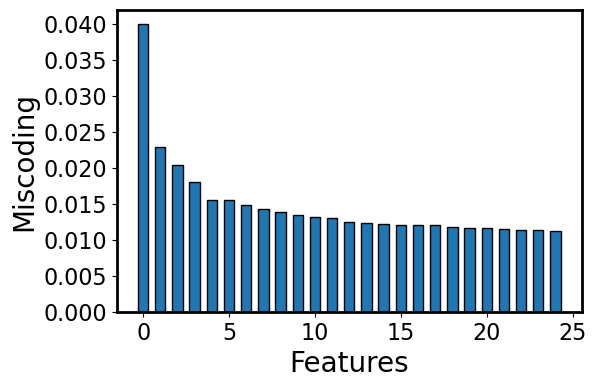

In [16]:
if (visualization == True):
    xmlad_plt.barplot_miscoding(mscd, n_features)
    if (save_figures == True):
        plt.savefig('images/monroe_dataset/FL_miscoding.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

## Identification of problematic attributes and experiments

In [17]:
all_ratios = np.array([])
for i in range(len(attributes)):
    attr = data[attributes[i]]
    scaler = StandardScaler()
    scaler.fit(attr.values.reshape(-1, 1))
    data2prc = scaler.transform(attr.values.reshape(-1, 1))
    clustering, centroidsxx, covariances, _ = xmlad_mod.model_based_clustering(data2prc, 5, 1234, 'spherical')
    classes = np.unique(clustering)
    
    if (classes.shape[0] > 1):
        ratio = np.zeros(classes.shape[0])
        for ii in range(classes.shape[0]):
            ratio[ii] = y_diff[clustering==classes[ii]].mean()
        all_ratios = np.append(all_ratios, ratio)
all_ratios = all_ratios[np.argsort(-all_ratios)]
num_prob_att = np.ceil(np.log2(np.log2(len(y_diff))/2)).astype(int)

In [18]:
k = 0
kk = 0
while (k != num_prob_att):
    models = pd.DataFrame({"Attribute":pd.Series(dtype='str'),
                          "best_model":pd.Series(dtype='str'),
                          "Class_1":pd.Series(dtype='float'),
                          "Class_2":pd.Series(dtype='float')})
    threshold = all_ratios[kk]
    print('Threshold: %.2f'%(threshold))
    k=0
    kk += 1
    for i in range(len(attributes)):
        attr = data[attributes[i]]
        scaler = StandardScaler()
        scaler.fit(attr.values.reshape(-1, 1))
        data2prc = scaler.transform(attr.values.reshape(-1, 1))
        clustering, _, _, _= xmlad_mod.model_based_clustering(data2prc, 5, 1234, 'spherical')
        classes = np.unique(clustering) 
        class_problem = np.zeros(clustering.shape)
   
        if (classes.shape[0] > 1):
            for ii in range(classes.shape[0]):
                ratio = y_diff[clustering==classes[ii]].mean()
                if ((ratio <= threshold) & (clustering[clustering==classes[ii]].shape[0] > 0.1*clustering.shape[0])):
                    class_problem[clustering==classes[ii]]=1
                else:
                    class_problem[clustering==classes[ii]]=2
            problem_classes = np.unique(class_problem)
            if (problem_classes.shape[0] > 1):
                if (k==0):
                    cls_mat = class_problem.reshape(-1,1)
                else:
                    cls_mat= np.hstack((cls_mat, class_problem.reshape(-1,1)))
                k=k+1            
                counts = np.array([class_problem[class_problem==1].shape[0], class_problem[class_problem==2].shape[0]])
                total  = np.sum(counts)
                models = models.append({'Attribute':attributes[i],
                                          'best_model':'best_model',
                                          'Class_1':counts[0]/total,
                                          'Class_2':counts[1]/total},ignore_index=True)
print(models)

Threshold: 0.00
Threshold: 0.00
Threshold: 0.00
Threshold: 0.00
Threshold: 0.00
Threshold: -0.00
Threshold: -0.00
Threshold: -0.01
Threshold: -0.01
Threshold: -0.01
Threshold: -0.01
Threshold: -0.01
Threshold: -0.01
Threshold: -0.02
Threshold: -0.02
Threshold: -0.02
Threshold: -0.02
Threshold: -0.02
Threshold: -0.02
Threshold: -0.02
Threshold: -0.02
Threshold: -0.03
Threshold: -0.03
Threshold: -0.03
Threshold: -0.03
Threshold: -0.03
Threshold: -0.04
Threshold: -0.04
Threshold: -0.04
Threshold: -0.04
Threshold: -0.04
Threshold: -0.05
Threshold: -0.05
Threshold: -0.05
Threshold: -0.06
Threshold: -0.06
Threshold: -0.06
Threshold: -0.06
Threshold: -0.06
Threshold: -0.07
Threshold: -0.07
Threshold: -0.07
Threshold: -0.08
Threshold: -0.08
Threshold: -0.09
Threshold: -0.09
Threshold: -0.09
Threshold: -0.10
Threshold: -0.10
Threshold: -0.10
Threshold: -0.10
Threshold: -0.10
Threshold: -0.11
Threshold: -0.11
Threshold: -0.11
Threshold: -0.11
Threshold: -0.11
Threshold: -0.11
Threshold: -0.11
Th

In [19]:
attributes = models["Attribute"].values
attributes, att_ind = np.unique(attributes, return_index=True)
cls_mat = cls_mat[:,att_ind]

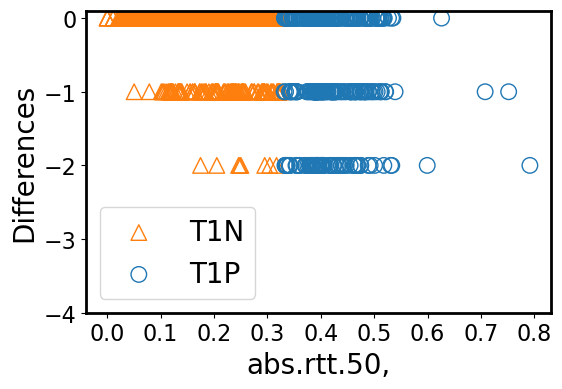

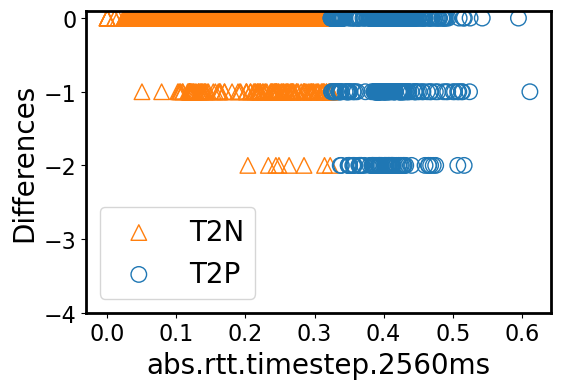

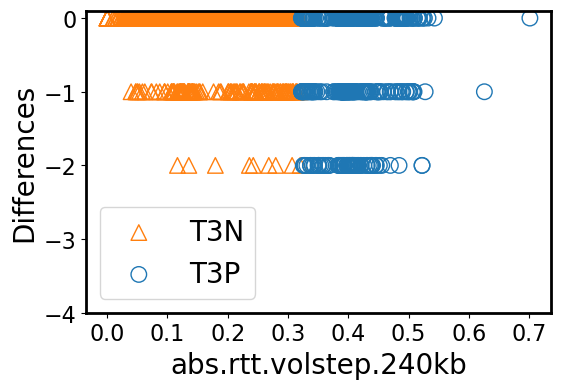

In [20]:
if (visualization == True):
    k = 0;
    for attr in attributes:
        cls_vec = cls_mat[:,k]
        bl_vec1 = (cls_vec==1)
        bl_vec2 = (cls_vec==2)
    
        fig = plt.figure(dpi=100) #Paper figure
        ax = fig.add_subplot()
        plt.scatter(data[attr][bl_vec2], data["Diff_Pred"][bl_vec2], label='T%dN'%(k+1), marker='^',color='tab:orange',s=125, facecolors='none')
        plt.scatter(data[attr][bl_vec1], data["Diff_Pred"][bl_vec1], label='T%dP'%(k+1), marker='o',color='tab:blue',s=125, facecolors='none')
        plt.legend(fontsize=20, loc='lower left' )
        plt.xlabel(attr.replace('_','\_'), fontsize=20)
        plt.ylabel("Differences", fontsize=20)
        plt.yticks([-4, -3,-2, -1, 0], fontsize=16)
        plt.xticks(fontsize=16)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2.0)  # change width
        k = k+1
        if (save_figures == True):  
            plt.savefig('images/monroe_dataset/FL_problematic_features_%02d.png'%(k),
                        format = 'png',
                        bbox_inches='tight', 
                        pad_inches=0)
        plt.show()    

## Generation of anomaly classification labels 

In [21]:
problem = np.empty(cls_mat.shape[0], dtype=object)
separator = ';'
for ii in range(cls_mat.shape[0]):    
    strings = []
    for jj in range(cls_mat.shape[1]):
        if (cls_mat[ii,jj] == 1):
            strings = strings + ['T%dP'%(jj+1)]
        if (cls_mat[ii,jj] == 2):
            strings = strings + ['T%dN'%(jj+1)]
    problem[ii] = separator.join(strings)    

## Building the anomaly classification engine

In [22]:
X            = data.copy()
X['Problem'] = problem
X.loc[X.Problem.str.contains('^[^P]+$'), "Problem"] = "Compliant"    
fX           = X.copy()
fy           = fX["Problem"]
fX           = fX.drop(["Problem", "Diff_Pred", target_kpi], axis=1)
depth = np.ceil(np.log2(np.sum(fy != "Compliant"))/2)

classifier, scores, ccp_alphas, best_alpha = xmlad_mod.build_decision_tree(depth, 5, fX, fy, None)

/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/juan/anaconda3

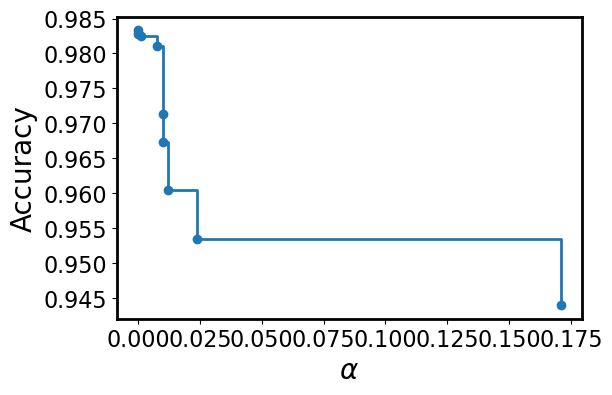

In [23]:
if (visualization == True):
    xmlad_plt.plot_pruning(ccp_alphas, scores)
    if (save_figures == True):  
        plt.savefig('images/monroe_dataset/FL_model2_optimization.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

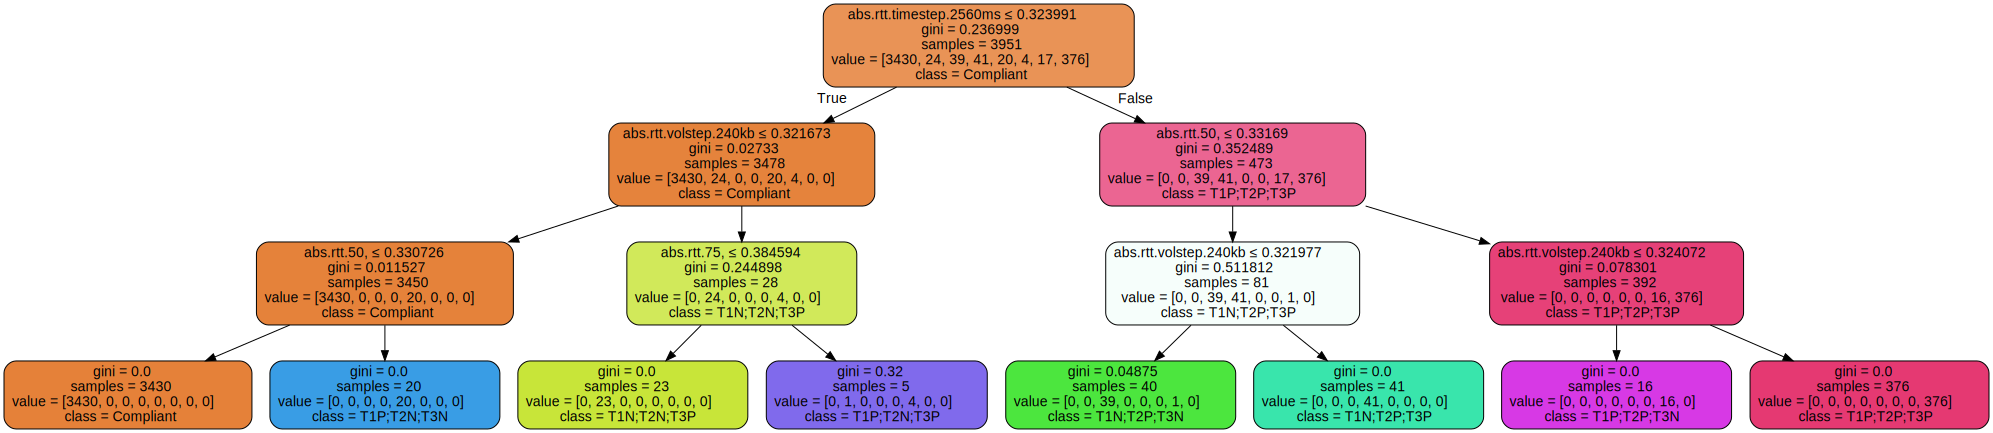

In [24]:
dot_data = tree.export_graphviz(classifier, 
                                feature_names = np.array(fX.columns), 
                                class_names=classifier.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=6,
                                special_characters=True)

graph = graphviz.Source(dot_data)
#graph.format='svg'
graph.format='png'
filename = graph.render(filename='models/monroe_dataset/model2_file_dl')
graph